In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Deep Convolutional Neural Network (Deep ConvNet)


![convnet](http://benanne.github.io/images/architecture.png)
* It is useful if and only if your data has a **topology** and has **local patterns**.
* Same as the standard neural network except that...
    * network **connections are sparse**.
    * weight parameters are **shared** among all the locations. 

## Convolution Layer
![conv](http://ufldl.stanford.edu/tutorial/images/Convolution_schematic.gif)
* Convolution layer consists of **convolution operation** and **non-linear activation**.
* Why convolution?
* **Convolution is a linear operation**
e.g., 1-D Convolution with single kernel:
$$h = \sigma (x \tilde{w}+b)$$
where $w$ is a kernel $w=(w_1,w_2,w_3)$ and $\tilde{w}$ is the **toeplitz matrix** build from $w$: $\tilde{w} = \pmatrix{
w_1 & 0   & 0   \\ 
w_2 & w_1 & 0   \\
w_3 & w_2 & w_1 \\
0   & w_3 & w_2 \\
0   & 0   & w_3}$

## Pooling Layer
![pool](http://ufldl.stanford.edu/tutorial/images/Pooling_schematic.gif)
* Pooling is an operation that **summarizes** neighboring nodes
* By using pooling, **spatial resolution is lost** but the representation gets more **robust to the translation-noise**.
* Also you get a representation with **reduced dimensionality**.
* There are many pooling operations but **max-pooling** is used in most cases.

## Fully-Connected Layer
* If the spatial dimensions are moderately reduced, there is no reason to do convolution or pooling, so we use a fully-connected layer.
* It is the same as the layers in standard neural network.


---
## Implementation

Now let's implement ConvNet in `tensorflow`!

We use the structure:

1. **CONV**: kernel(3x3x1x10) maps (Nx28x28x1) to (Nx26x26x10)
1. **CONV**: kernel(3x3x10x10) maps (Nx26x26x10) to (Nx24x24x10)
1. **POOL**: max-pool(2x2) maps (Nx24x24x10) to (Nx12x12x10)
1. **CONV**: kernel(3x3x10x20) maps (Nx12x12x10) to (Nx10x10x20)
1. **POOL**: max-pool(2x2) maps (Nx10x10x20) to (Nx5x5x20)
1. **CONV**: kernel(3x3x20x20) maps (Nx5x5x20) to (Nx3x3x20)
1. **FLAT**: flattening maps (Nx3x3x20) to (Nx180)
1. **FULL**: weight(180x40) maps (Nx180) to (Nx40)
1. **LogR**: weight(40x10) maps (Nx40) to (Nx10)

Note that:
* kernel shape:  (size_h, size_w, n_channel, n_kernel)
* feature shape: (n_data, size_h, size_w, n_channel)


### ConvLayer

In [4]:
layer_spec = [
    {"type": "conv", "shape": (3,3,1,10)},
    {"type": "conv", "shape": (3,3,10,10)},
    {"type": "pool", "shape": (2,2)},
    {"type": "conv", "shape": (3,3,10,20)},
    {"type": "pool", "shape": (2,2)},
    {"type": "conv", "shape": (3,3,20,20)},
    {"type": "flat", "shape": 180},
    {"type": "full", "shape": (180,40)},
    {"type": "logr", "shape": (40,10)}
]


tf.reset_default_graph()
x = tf.placeholder('float32', shape=[None,28,28,1], name='x')
inp = x
for l,layer in enumerate(layer_spec):
    ltype = layer["type"]
    lshape = layer["shape"]
    
    if ltype == "conv":
        with tf.name_scope('conv{}'.format(l)):
            k = tf.Variable(
                tf.truncated_normal(shape=lshape, mean=0.0, stddev=0.05),
                name="kernel"
            )
            b = tf.Variable(tf.zeros((lshape[-1],)), name="bias")
            convout = tf.nn.conv2d(inp,k,strides=(1,1,1,1),
                                   padding="VALID")
            p = tf.nn.bias_add(convout, b)
            h = tf.nn.relu(p)
            inp = h
            
    elif ltype == "pool":
        with tf.name_scope('pool{}'.format(l)):
            out = tf.nn.max_pool(inp, ksize=(1,)+lshape+(1,), 
                                strides=(1,)+lshape+(1,), 
                                padding="VALID")
            inp = out
            
    elif ltype == "flat":
        with tf.name_scope('flat{}'.format(l)):
            out = tf.reshape(inp, (-1,lshape))
            inp = out
    
    elif ltype == "full":
        with tf.name_scope('full{}'.format(l)):
            w = tf.Variable(
                tf.truncated_normal(
                    shape=lshape,
                    mean=0.0, stddev=0.05),
                name='weight'
            )
            b = tf.Variable(tf.zeros(lshape[-1],), name="bias")
            p = tf.nn.bias_add(tf.matmul(inp, w), b)
            h = tf.nn.relu(p)
            inp = h
    elif ltype == "logr":
        with tf.name_scope('logr{}'.format(l)):
            assert l == len(layer_spec)-1
            w = tf.Variable(
                tf.truncated_normal(
                    shape=lshape,
                    mean=0.0, stddev=0.05),
                name='weight'
            )
            b = tf.Variable(tf.zeros(lshape[-1],), name="bias")
            p = tf.nn.bias_add(tf.matmul(inp, w), b)
            final_out = p

            
            
t = tf.placeholder('int32', name='t')
xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            final_out, t, name='xent')

loss = tf.reduce_mean(xent, name='loss')
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

#pred = tf.argmax(final_out, axis=1)
pred = tf.reduce_max(final_out, reduction_indices=[1])
correct = tf.nn.in_top_k(final_out, t, 1)
acc = tf.reduce_mean(tf.cast(correct, tf.float32))


In [5]:
try:
    sess.close()
except NameError:
    pass
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Load values on GPU
init = tf.initialize_all_variables()
sess.run(init) 


[u'test_t', u'test_x', u'train_t', u'train_x', u'valid_t', u'valid_x']
(55000, 784)
class:  7


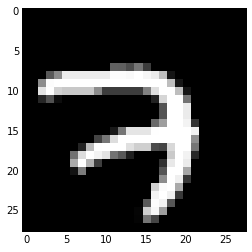

In [6]:
import h5py
mnist = h5py.File('../mnist.hdf5','r')
print mnist.keys()
print mnist['train_x'].shape

train_x = mnist['train_x'][()]
train_t = mnist['train_t'][()]

plt.imshow(train_x[0].reshape((28, 28)), 
               interpolation='nearest', cmap=plt.get_cmap('gray'))
print "class: ", train_t[0]

In [8]:

num_train = train_x.shape[0]
mb_size = 200
num_mbs = int(num_train / mb_size)

loss_history = []
for epoch in xrange(30):
    loss_vals = []
    acc_vals = []
    for mb in xrange(num_mbs):
        data_x = np.reshape(
                train_x[mb*mb_size : (mb+1)*mb_size],
                (-1,28,28,1) )
        data_t = train_t[mb*mb_size : (mb+1)*mb_size] 

        _, loss_val, acc_val = sess.run([train_step, loss, acc], 
                                            feed_dict={x: data_x, t: data_t})
        loss_vals.append(loss_val)
        acc_vals.append(acc_val)
        
    print "Epoch: {}, Loss: {}, Acc: {}".format(
        epoch, np.mean(loss_vals), np.mean(acc_vals) )

    loss_history.append(np.mean(loss_vals))

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Epoch: 0, Loss: 2.30163168907, Acc: 0.111945450306
Epoch: 1, Loss: 2.30107355118, Acc: 0.112345457077
Epoch: 2, Loss: 2.30078005791, Acc: 0.112345457077
Epoch: 3, Loss: 2.30003643036, Acc: 0.112345457077
Epoch: 4, Loss: 2.29410076141, Acc: 0.12056363374
Epoch: 5, Loss: 0.987143576145, Acc: 0.687909126282
Epoch: 6, Loss: 0.237517669797, Acc: 0.925909101963
Epoch: 7, Loss: 0.153402969241, Acc: 0.951127290726
Epoch: 8, Loss: 0.116064816713, Acc: 0.963127195835
Epoch: 9, Loss: 0.0958796963096, Acc: 0.969327270985
Epoch: 10, Loss: 0.0835333317518, Acc: 0.973418176174
Epoch: 11, Loss: 0.0745419561863, Acc: 0.976436316967


KeyboardInterrupt: 

In [9]:
test_x = mnist['test_x']
test_t = mnist['test_t']
test_mb_size = 200
test_num_mbs = test_x.shape[0] / test_mb_size

test_accs = []
for mb in xrange(test_num_mbs):
    test_acc = sess.run(acc, feed_dict={
        x: np.reshape(
            test_x[mb*test_mb_size : (mb+1)*test_mb_size],
            (-1,28,28,1) ),
        t: test_t[mb*test_mb_size : (mb+1)*test_mb_size]})
    test_accs.append(test_acc)
print "test acc: ", np.mean(test_accs)

test acc:  0.9789
